In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import csv
import pickle
#import os
import re
import string
import unicodedata
import nltk
nltk.download("punkt")
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# code_preparation

In [2]:
df0 = pd.read_csv('../spam_filter/data/raw/SMSSpamCollection.csv', sep='\t',names=["message"], 
                  encoding='ISO-8859-1',index_col=False)
df0.head()

,message
0,"ham,Go until jurong point, crazy.. Available o..."
1,"ham,Ok lar... Joking wif u oni..."
2,"spam,Free entry in 2 a wkly comp to win FA Cup..."
3,"ham,U dun say so early hor... U c already then..."
4,"ham,Nah I don't think he goes to usf, he lives..."


In [3]:
df0[['label', 'text']] = df0['message'].str.split(',', 1, expand=True)
df0.head()

,message,label,text
0,"ham,Go until jurong point, crazy.. Available o...",ham,"Go until jurong point, crazy.. Available only ..."
1,"ham,Ok lar... Joking wif u oni...",ham,Ok lar... Joking wif u oni...
2,"spam,Free entry in 2 a wkly comp to win FA Cup...",spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,"ham,U dun say so early hor... U c already then...",ham,U dun say so early hor... U c already then say...
4,"ham,Nah I don't think he goes to usf, he lives...",ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
del df0['message']
df0.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df = df0.to_csv('../spam_filter/data/processed/SMSSpamColl.csv', index=False)

In [6]:
df = pd.read_csv('../spam_filter/data/processed/SMSSpamColl.csv', encoding='utf-8')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df = df[['text','label']]
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
df.shape

(5574, 2)

In [9]:
df['text'].isna().sum()

0

In [10]:
df['label'].isna().sum()

0

In [14]:
#labeling
reviews = np.array(df0['text'])[:]
labels = np.array(df0['label'])[:]
Counter(labels)

Counter({'ham': 4827, 'spam': 747})

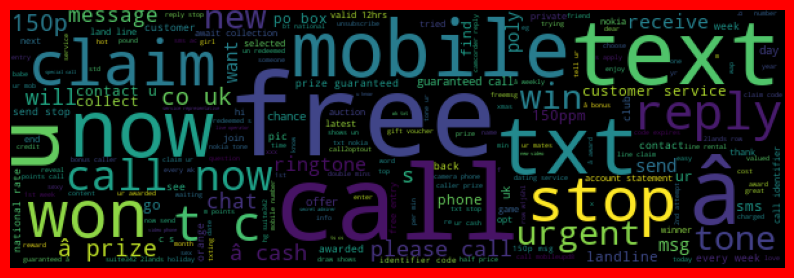

In [17]:
# Plotting the word cloud of spam words

spam_words = ""

# Loop all texts where label is 'spam'
for value in df[df['label'] == 'spam'].text:
    lowercase_text = value.lower()
    tokens = nltk.word_tokenize(lowercase_text)
    for word in tokens:
        spam_words = spam_words + word + ' '

spam_wordcloud = WordCloud(background_color="Black", width=600, height=200).generate(spam_words)

# Plot the word cloud 
plt.figure( figsize=(10,10), facecolor='r')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.savefig('../spam_filter/docs/images/spam_wordcloud.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

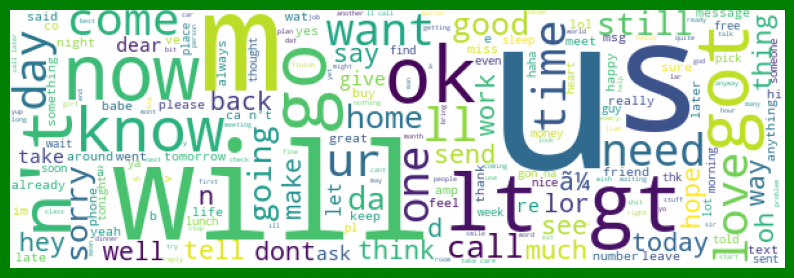

In [18]:
# Plotting the word cloud of NOT spam words

ham_words = ""

# Loop all texts where label is 'ham'
for value in df[df['label'] == 'ham'].text:
    lowercase_text = value.lower()
    tokens = nltk.word_tokenize(lowercase_text)
    for word in tokens:
        ham_words = ham_words + word + ' '

ham_wordcloud = WordCloud(background_color="White", width=600, height=200).generate(ham_words)

# Plot the word cloud 
plt.figure( figsize=(10,10), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.savefig('../spam_filter/docs/images/ham_wordcloud.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

# code_model_selection

## Cleaning

In [19]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
    return tokens    

## Vectorizer tf-idf

In [20]:
cv=TfidfVectorizer(lowercase=True,preprocessor=clean_text,stop_words='english',
                   ngram_range=(1,3),tokenizer=tokenize)

text_counts=cv.fit_transform(df['text'].values.astype('U'))

## Split into training and testing data

In [21]:
x_train, x_test, y_train, y_test = train_test_split(text_counts,df['label'],test_size=0.3)

## Logistic regression Classifier

In [22]:
# Logistic Regression
clf = LogisticRegression(C=0.3)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.8744769874476988

## Logistic regression + L1 Regulation

In [23]:
# Logistic Regression
clf = LogisticRegression(penalty='l1', solver = 'saga', C=0.3)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)
print("Accuracy with L1 regularization: ", metrics.accuracy_score(y_test, y_pred))

Accuracy with L1 regularization:  0.9079497907949791


## Logistic regression + L1 Regulation + Cross Validation

In [24]:
clf = LogisticRegression(penalty='l1', solver = 'saga', C=0.3)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L1 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.88627049 0.88512821 0.88923077 0.87897436]
Average Cross Validation Score:  0.884900956284153
Accuracy with L1 regularization and cross validation:  0.9079497907949791


## Logistic regression + L2 Regulation + Cross Validation

In [25]:
clf = LogisticRegression(penalty='l2', solver = 'lbfgs', C=0.3)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)
print("Accuracy with L2 regularization: ", metrics.accuracy_score(y_test, y_pred))

Accuracy with L2 regularization:  0.8744769874476988


In [26]:
clf = LogisticRegression(penalty='l2', solver = 'lbfgs', C=0.3)
scores = cross_val_score(clf, x_train, y_train, cv=6)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L2 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.86175115 0.86461538 0.86307692 0.86461538 0.86307692 0.86461538]
Average Cross Validation Score:  0.8636251920122887
Accuracy with L2 regularization and cross validation:  0.8744769874476988


In [27]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      1461
        spam       1.00      0.01      0.02       212

    accuracy                           0.87      1673
   macro avg       0.94      0.50      0.48      1673
weighted avg       0.89      0.87      0.82      1673



## Bernoulli NB Classifier

In [28]:
#Ber_NB
clf=BernoulliNB()
clf.fit(x_train,y_train)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9240884638374178

## Bernoulli NB + Cross validation

In [29]:
#Ber_NB with cross validation
clf = BernoulliNB()
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy with cross validation: ", scores.mean())

Accuracy with cross validation:  0.8802869431038445


In [30]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.92      1.00      0.96      1461
        spam       0.99      0.41      0.58       212

    accuracy                           0.92      1673
   macro avg       0.95      0.70      0.77      1673
weighted avg       0.93      0.92      0.91      1673



## Gaussian Naive Bayes Classifier

In [31]:
#Single Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
x_train_dense = np.array(x_train.toarray())
x_test_dense = np.array(x_test.toarray())
clf.fit(x_train_dense, y_train)
y_pred = clf.predict(x_test_dense)
metrics.accuracy_score(y_test, y_pred)

0.9258816497310222

In [32]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.98      0.93      0.96      1461
        spam       0.65      0.88      0.75       212

    accuracy                           0.93      1673
   macro avg       0.82      0.91      0.85      1673
weighted avg       0.94      0.93      0.93      1673



## Linear SVC Classifier

In [33]:
#Linear SVC
clf = svm.LinearSVC()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9701135684399282

# Linear SVC + L1 Regulation + Cross Validation

In [34]:
clf = svm.LinearSVC(penalty='l1', loss='squared_hinge', C=0.3, dual=False)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L1 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.93442623 0.93641026 0.93948718 0.94564103]
Average Cross Validation Score:  0.9389911727616645
Accuracy with L1 regularization and cross validation:  0.9515839808726838


# Linear SVC + L2 Regulation + Cross Validation

In [35]:
clf = svm.LinearSVC(penalty='l2', C=0.3, dual=False)
scores = cross_val_score(clf, x_train, y_train, cv=4)
print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", np.mean(scores))

clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy with L2 regularization and cross validation: ", metrics.accuracy_score(y_test, y_pred))

Cross Validation Scores:  [0.94877049 0.94666667 0.95076923 0.94461538]
Average Cross Validation Score:  0.9477054434636403
Accuracy with L2 regularization and cross validation:  0.9593544530783025


In [36]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1461
        spam       1.00      0.68      0.81       212

    accuracy                           0.96      1673
   macro avg       0.98      0.84      0.89      1673
weighted avg       0.96      0.96      0.96      1673



## Support Vector Machines Classifier

In [37]:
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9736999402271369

## Support Vector Machines + Cross validation¶

In [38]:
clf = SVC(kernel='linear')
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy of SVM with cross validation: ", scores.mean())

Accuracy of SVM with cross validation:  0.9720571916346564


In [39]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1461
        spam       0.99      0.80      0.89       212

    accuracy                           0.97      1673
   macro avg       0.98      0.90      0.94      1673
weighted avg       0.97      0.97      0.97      1673



## Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9599521817095039

## Decision Tree Classifier + Cross validation

In [41]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x_train, y_train, cv = 10)
print("Accuracy of Decision Tree with Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of Decision Tree with Cross Validation: 0.97 (+/- 0.01)


In [42]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1461
        spam       0.86      0.81      0.84       212

    accuracy                           0.96      1673
   macro avg       0.92      0.90      0.91      1673
weighted avg       0.96      0.96      0.96      1673



In [43]:
#!pip install xgboost

In [44]:
#XGBoost Classifier
#import xgboost as xgb
#from sklearn.preprocessing import LabelEncoder

#Encode the labels as integers
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.transform(y_test)

#Fit the XGBoost classifier
#clf = xgb.XGBClassifier()
#clf.fit(x_train, y_train)
#y_pred = clf.predict(x_test)
#metrics.accuracy_score(y_test, y_pred)

## Multinomial Naive Bayes Classifier

In [45]:
#Multinomial Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.3)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.9826658696951583

## Multinomial Naive Bayes + Cross validation

In [46]:
clf = MultinomialNB(alpha=0.3)
scores = cross_val_score(clf, x_train, y_train, cv=5)
print("Accuracy of Multinomial Naive Bayes with cross validation: ", scores.mean())

Accuracy of Multinomial Naive Bayes with cross validation:  0.9782087396171903


## Classification report
Model with high accuracy but low precision might be overfitting.

Model with a low accuracy but high precision might be underfitting.

Model with a high f1-score means have a good balance between accuracy and recall, have better overall performance.

In [47]:
#Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1461
        spam       0.99      0.87      0.93       212

    accuracy                           0.98      1673
   macro avg       0.99      0.93      0.96      1673
weighted avg       0.98      0.98      0.98      1673



## Confusion matrix

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print("")

[[1460    1]
 [  28  184]]



## Normalized Confusion matrix

In [49]:
nconf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis],1)
print(nconf_matrix)

[[1.  0. ]
 [0.1 0.9]]


The confusion matrix is a table that shows the number of true positive, true negative, false positive, and false negative predictions made by the model. The confusion matrix shows the number of times the model correctly (true positive and true negative) and incorrectly (false positive and false negative) predicted each class.


# Heatmap of confusion matrix

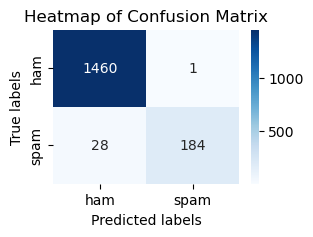

In [52]:
# Create a LabelEncoder object
le = LabelEncoder()
le.fit(labels)
class_labels = le.classes_
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Heatmap of Confusion Matrix")
plt.savefig('../spam_filter/docs/images/heatmap_confusion_matrix.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

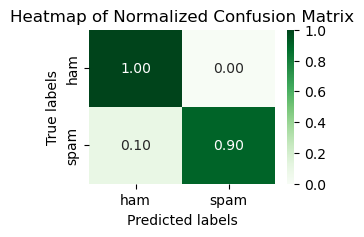

In [53]:
# Heatmap of Normalized confusion matrix, to make the entries in the matrix more easily comparable
plt.figure(figsize=(3, 2))
sns.heatmap(nconf_matrix, annot=True, cmap=plt.cm.Greens, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Heatmap of Normalized Confusion Matrix")
# Save the chart to a file
plt.savefig('../spam_filter/docs/images/normalized_confusion_matrix.jpeg',
            transparent=False, bbox_inches='tight',pad_inches=0.1)
plt.show()

# code_model_deploy

## Save the chosen model and Vectorizer 

In [54]:
def train_models():
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pickle','wb')
    pickle.dump(cv, file)
    file.close()

    file = open('../spam_filter/src/code_model_deploy/model.pickle','wb')
    pickle.dump(clf, file)
    file.close()
    
    print("Models saved")

In [55]:
train_models()

Models saved


## Load model and Vectorizer

In [56]:
def load_models():  
       
    # Load the vectorizer.
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../spam_filter/src/code_model_deploy/model.pickle', 'rb')
    model = pickle.load(file)
    file.close()
    
    return vectorizer, model

In [57]:
#!pip install streamlit

# main_code

In [58]:
#%%writefile spam_classifier.py

import streamlit as st
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)    
    return tokens

def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]    
    return ' '.join(stems)   

def load_models():  
    # Load the vectorizer.
    file = open('../spam_filter/src/code_model_deploy/vectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../spam_filter/src/code_model_deploy/model.pickle', 'rb')
    model = pickle.load(file)
    file.close()
    return vectorizer, model

def predict(text):
    processed_text = clean_text(text)
    test_counts = vectorizer.transform([processed_text])
    prediction = model.predict(test_counts)
    return prediction[0]

def main():
    st.title("Spam Filter")
    
    text = st.text_input("Enter your text:")
    
    if st.button("Predict"):
        if text == "":
            st.warning("Please enter a text to classify")
        else:
            result = predict(text)
            st.success(f"The input text is classified as: {result}")

if __name__ == '__main__':
    vectorizer, model = load_models()
    main()

2023-02-14 00:06:56.513 
  command:

    streamlit run C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py [ARGUMENTS]
